In [3]:
!python -m pip install gitpython pandas matplotlib altair

You should consider upgrading via the '/home/max/Dokumente/Projects/fds-pankow/.venv/bin/python -m pip install --upgrade pip' command.


In [4]:
import git
from glob import glob
import json
import pandas as pd
from collections import defaultdict

## Data overview

- Around 1,000 businesses were checked since scraping started.
- There are ~1,400 data points recorded
- 50%

In [5]:
root_dir = "results"
repo = git.Repo(root_dir)

tree = repo.heads.master.commit.tree

paths = glob("pankow/*/*.json", root_dir=root_dir)
print(len(paths))

981


In [6]:
changes = {}
for path in paths:
  changes[str(path)] = 0

  revlist = (
      (commit, (commit.tree / path).data_stream.read())
      for commit in repo.iter_commits(paths=path)
  )

  for commit, filecontents in revlist:
      changes[str(path)] += 1

In [7]:
df = pd.Series(dict.values(changes))
print(df.describe())
print("all checks", df.sum())

count    981.000000
mean       1.433231
std        0.717761
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        6.000000
dtype: float64
all checks 1406


In [8]:
print("no. of businesses that were changed only once: ", df[df == 1].count())
print("percentage: ", df[df == 1].count() / df.count()) 

no. of businesses that were changed only once:  653
percentage:  0.6656472986748216


In [9]:
print(set(dict.values(changes)))

print("these were changed >=5 times:")
for path, n in dict.items(changes):
  if n >= 5:
    print(path)

{1, 2, 3, 4, 5, 6}
these were changed >=5 times:
pankow/66CED98AA4347EA9E0536884190AB2B4/66CED98AA4347EA9E0536884190AB2B4.json
pankow/8AA3AF280F323AD9E0536884190A162D/8AA3AF280F323AD9E0536884190A162D.json
pankow/A73BFA02A79A46B1AC76D5F2779F59FC/A73BFA02A79A46B1AC76D5F2779F59FC.json
pankow/F0232313B29A42768802B5A2A7FD395C/F0232313B29A42768802B5A2A7FD395C.json
pankow/593546B77E5D6398E0536884190A25D5/593546B77E5D6398E0536884190A25D5.json
pankow/7CDABEED7B9B49699C477FEF5E0A6B46/7CDABEED7B9B49699C477FEF5E0A6B46.json


## Helper functions

In [10]:
def get_inspections():
  for path in paths:
    business = {}

    revlist = (
        (commit, (commit.tree / path).data_stream.read())
        for commit in repo.iter_commits(paths=path)
    )

    for commit, filecontents in revlist:
        data = json.loads(filecontents)
        business[data["results"]["date"]] = data
    
    for inspection in dict.values(business):
        yield inspection

inspections = list(get_inspections())

## Categories over time

<AxesSubplot:xlabel='date'>

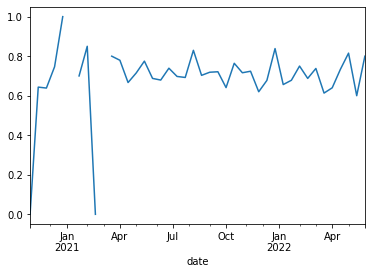

In [11]:
categories = []

for inspection in inspections:
    categories.append(
        {
            "date": pd.Timestamp(inspection["results"]["date"]),
            **{
                detail["property"]: int(detail["achievedPoints"]) / int(detail["possiblePoints"])
                for detail in inspection["details"]
            },
        }
    )

df = pd.DataFrame(categories)
df.set_index('date', inplace=True)
# df.sort_index().head()
df["Einhaltung LM-rechtlicher Bestimmungen"].resample("2w").mean().plot()


## Follow-up checks

In [16]:
follow_up_results = set()

for inspection in inspections:
    for follow_up in inspection["followUps"]:
        follow_up_results.add(follow_up["result"])

print(follow_up_results)


ratings = (
    (78, "sehr gut"),
    (60, "gut"),
    (39, "zufriedenstellend"),
    (21, "ausreichend"),
    (0, "nicht ausreichend")
)
rating_categories = [rating[1] for rating in ratings]

results = defaultdict(lambda: defaultdict(lambda: 0))

for inspection in inspections:
    conclusion = inspection["results"]["conclusion"]
    for follow_up in inspection["followUps"]:
        follow_up_result = follow_up["result"]
        results[conclusion][follow_up_result] += 1
        break

print(dict.keys(results))
print(results)


#df = pd.DataFrame(results, index=rating_categories)
#df.set_index(rating_categories, inplace=True)
#df.head()



{'Verstoß mit Maßnahme', 'Mängel überwiegend abgestellt', 'Mängel vollständig abgestellt', 'Mängel teilweise abgestellt', 'Verstoß', 'Mängel nicht abgestellt', 'offen / in Arbeit'}
dict_keys(['gut', 'nicht ausreichend', 'ausreichend', 'zufriedenstellend', 'zufriedenstellend\nzufriedenstellend', 'ausreichend\nausreichend', 'ausreichend\nzufriedenstellend', 'zufriedenstellend\nausreichend', 'nicht ausreichend\nausreichend', 'nicht ausreichend\nnicht ausreichend', 'ausreichend\nnicht ausreichend', 'gut\nzufriedenstellend', 'sehr gut', 'zufriedenstellend\ngut', 'zufriedenstellend\nnicht ausreichend'])
defaultdict(<function <lambda> at 0x7f3ea96c81f0>, {'gut': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f3eaa1d05e0>, {'Mängel teilweise abgestellt': 9, 'Mängel überwiegend abgestellt': 9, 'Mängel vollständig abgestellt': 11}), 'nicht ausreichend': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f3eaa1d0550>, {'Mängel teilweise abgestellt': 38, 'Mängel vollständig abgestellt'

In [42]:
# to compare files with e.g. `diff`

import time

def historize(id):
  path = f"pankow/{id}/{id}.json"

  revlist = (
      (commit, (commit.tree / path).data_stream.read())
      for commit in repo.iter_commits(paths=[path])
  )

  i = 0
  for commit, filecontents in reversed(list(revlist)):
    i += 1
    print(time.strftime("%a, %d %b %Y", time.localtime(commit.committed_date)))
    
    with open(f"deltas/{i}.json", "w") as file:
      file.write(json.dumps(json.loads(filecontents), indent=4))
      
historize("1A5D62F9893A41E78BCF76BF177D42AD")

Wed, 30 Dec 2020
Sun, 20 Mar 2022
Thu, 14 Apr 2022
